In [149]:
import requests
import re
import warnings
import urllib.request

from webbot import Browser
from selenium import webdriver

from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from webdriver_manager.chrome import ChromeDriverManager

import pandas as pd
from pandas import DataFrame
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [150]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [151]:
common_words_list = pd.read_csv("Common_Articles_List.csv")
personality = pd.read_csv("Personality.csv", sep=',')
software = pd.read_csv("Programming_Languages.csv")

common = common_words_list["word"].to_list()
personality = [x.lower() for x in personality["Traits"]]
software = [x.lower() for x in software["languages"]]
education = ["highschool", "ged", "bachelors", "masters", "doctorate", "phd", "internship"]

In [152]:
def chrome_engine():
    options = Options()
    options.binary_location = "C:\Program Files\Google\Chrome\Application\chrome.exe"
    driver = webdriver.Chrome(ChromeDriverManager().install())

    #User Input and Driver Link
    driver.get('https://indeed.com/')
    job_title = driver.find_element_by_id('text-input-what')
    job_title.send_keys("Data Analyst")
    location = driver.find_element_by_id("text-input-where")
    location.send_keys("test")
    locate_clear_field = driver.find_element_by_class_name("icl-TextInputClearable-icon")
    locate_clear_field.click()
    fixed_location = location.send_keys("Washington, DC")
    submit_button = driver.find_element_by_class_name("yosegi-InlineWhatWhere-primaryButton")
    submit_button.send_keys(Keys.RETURN)
    current_page_url = driver.current_url
    
    print("Chrome Engine Successful")
    print("Base Link: ", current_page_url)
    return current_page_url

In [153]:
def get_indeed_page_numbers(page):
    clock = False
    page_numbers_element = page.find_all("span", class_="pn", text=True)

    page_number_list = []
    for items in page_numbers_element:
        page_number_list.append("https://www.indeed.com" + items.parent["href"])
    
    if len(page_numbers_element) == 4:
        
        loop_counter = 5
        
        while clock is False:
            last_page = page_number_list[-1]
            analysis_page = requests.get(last_page)
            soup = BeautifulSoup(analysis_page.content, "html.parser")
            new_link_list = soup.find_all("span", class_="pn", text=True)
            
            try:
                additional_counter = int(new_link_list[-1].text) - loop_counter
            
                if additional_counter < 1: 
                    clock = True

                else: 
                    for items in new_link_list[(additional_counter * -1):]:
                        loop_counter = int(items.text)
                        page_number_list.append("https://www.indeed.com" + items.parent["href"])
                    clock = False
                    
            except IndexError:
                clock = True
        
        
    return page_number_list

In [154]:
def indeed_page_web_scrapper(current_page_url):
    indeed_url = "https://www.indeed.com"

    analysis_page = requests.get(current_page_url)
    soup = BeautifulSoup(analysis_page.content, "html.parser")


    additional_page_links = get_indeed_page_numbers(soup)

    print(len(additional_page_links), " Potential Jobs Pages")




    job_links = []    
    job_listings = soup.find_all('a', class_="tapItem")
    counter = 0
    for job in job_listings:
        job_links.append(indeed_url + job["href"])


    for page_link in additional_page_links:
        web_page = requests.get(page_link)
        soup = BeautifulSoup(web_page.content, "html.parser")
        job_listings = soup.find_all('a', class_="tapItem")


        for job in job_listings:
            job_links.append(indeed_url + job["href"])


    print("Total Jobs Analyzed: ", len(job_links))
    print("   ")
    return job_links

In [155]:
def job_description_cleaner(page_body_text):
    counter = 0
    unwanted_chars = [" ", ",", "/", "'\'", ".", "(", ")", ";", '"', "'", ":", "-", "_", 
                      "&", "[", "]", "*", "?", "#", "!", "%", "®", "“", '”', ":", "~"]

    additional_splitting = ["/", "(", ")", "%", "/", ".", "-", "/"]
    final_list = []
    word_frequency = {}

    for items in page_body_text:
        if items is not None:
            text = re.sub("\n", " ", items)
            clean_list = text.split()

            for word in clean_list:
                split_words = []
                if word != "":

                    if len(word) > 1:

                        cleaned = False
                        while cleaned is False:

                            if len(word) > 1 and word[len(word)-1] in unwanted_chars:
                                word = word[:-1]

                                if len(word) > 1 and word[0] in unwanted_chars:
                                    word = word[1:]


                            if len(word) > 1 and word[0] in unwanted_chars:
                                word = word[1:]

                                if len(word) > 1 and word[len(word)-1] in unwanted_chars:
                                    word = word[:-1]


                            if len(word) == 1:
                                if word in unwanted_chars:
                                    cleaned = True

                                else:
                                    final_list.append(word.lower().strip())
                                    cleaned = True

                            elif word[0] not in unwanted_chars and word[len(word) - 1] not in unwanted_chars:
        
                                if word[-2:] == "'s" or word[-2:] == "’s":
                                    word = word[:-2] + "s"

                                if "$" in word:
                                    word = "$" + word.split("$", 1)[1]

                                for symbols in additional_splitting:
                                    if symbols in word: 
                                        split_words = word.split(symbols)

                                if len(split_words) == 0: 
                                    final_list.append(word.lower().strip())
                                    cleaned = True
                                else: 
                                    for words in split_words:
                                        final_list.append(words.lower().strip())
                                        cleaned = True

                            else: 
                                cleaned = False

                    else: 
                        if word not in unwanted_chars:
                            final_list.append(word.lower().strip())
        
        else: 
            continue

    print("Cleaning Out Format Of Words!")
    print("Total Words For Analysis: ",len(final_list))
    print("   ")
    return final_list

In [156]:
def job_description_page(job_links):
    counter = 0
    page_body_text = []

    for job_page in job_links:
        loaded_page = requests.get(job_page)
        soup = BeautifulSoup(loaded_page.text, "html.parser")


        page_body = soup.find_all("div", class_="jobsearch-JobComponent-description")

        for elements in page_body:
            text = elements.get_text()

            page_body_text.append(text)
            counter += 1
            
    print("Analyzing Job Descriptions")
    print("Total Job Descriptions Readable: ", len(page_body_text))
    print("   ")
    return page_body_text

In [157]:
def word_counter(final_list):
    word_frequency= {}
    for words in final_list:
        if words not in word_frequency:
            word_frequency[words] = 1
        else:
            word_frequency[words] += 1

    for words in common: 
        if words in word_frequency.keys():
            del word_frequency[words]

    sorted_word_frequency_list = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)
    return sorted_word_frequency_list

In [162]:
def analytics(sorted_word_frequency_list):
    programming_languages = []
    personality_traits = []
    salary_expectations = []
    experience = [] 

    for items in sorted_word_frequency_list: 
        if items[0] in software:
            programming_languages.append(items)

        if items[0] in personality:
            personality_traits.append(items)

        if items[0] in education:
            experience.append(items)

        elif "$" in items[0] and len(items[0]) > 1:
            try:
                if "k" in items[0] and "-" not in items[0]: 
                    money = items[0]
                    test = int(money[:-1])
                    money = money[:-1] + ",000"
                    salary_expectations.append((money, items[1]))
                    continue
                    
            except ValueError:
                continue
                    
            if len(items[0]) <= 4:
                money = items[0]

                try:
                    money = int(money[1:])
                    if money < 250:
                        money = "$" + str(f'{(int(money[1:]) * 40 * 52):,}')
                        salary_expectations.append((money, items[1]))
                except ValueError:
                    continue

            

            else:
                try:
                    money = items[0]
                    money = "$" + str(f'{(int(money[1:])):,}')
                    salary_expectations.append((money, items[1]))
                except ValueError:
                    continue

    return programming_languages, personality_traits, salary_expectations, experience

In [11]:
current_page_url = chrome_engine()

job_links = indeed_page_web_scrapper(current_page_url)

page_body_text = job_description_page(job_links)

final_list = job_description_cleaner(page_body_text)

sorted_word_frequency_list = word_counter(final_list)

visualization_lists = analytics(sorted_word_frequency_list)




====== WebDriver manager ======
Current google-chrome version is 100.0.4896
Get LATEST chromedriver version for 100.0.4896 google-chrome
Trying to download new driver from https://chromedriver.storage.googleapis.com/100.0.4896.60/chromedriver_win32.zip
Driver has been saved in cache [C:\Users\13017\.wdm\drivers\chromedriver\win32\100.0.4896.60]


Chrome Engine Successful
Base Link:  https://www.indeed.com/jobs?q=Data%20Analyst&l=Washington%2C%20DC&vjk=278536d51c5d0081
63  Potential Jobs Pages
Total Jobs Analyzed:  700
   
Analyzing Job Descriptions
Total Job Descriptions Readable:  387
   
Cleaning Out Format Of Words!
Total Words For Analysis:  223320
   


In [12]:
visualization_lists = analytics(sorted_word_frequency_list)

<function matplotlib.pyplot.show(close=None, block=None)>

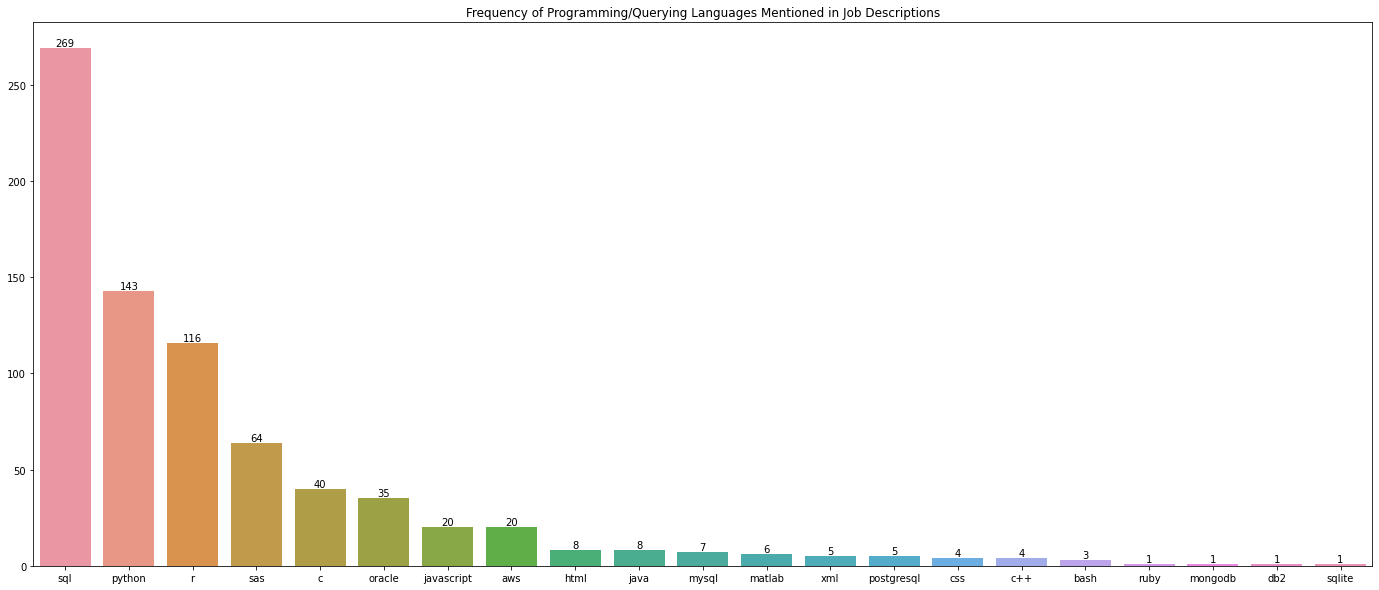

In [13]:
programming_lang = visualization_lists[0]
index = []
value = []
for items in programming_lang:
    index.append(items[0])
    value.append(items[1])
    
plt.figure(figsize=(24,10))
plt.title("Frequency of Programming/Querying Languages Mentioned in Job Descriptions")
ax = sns.barplot(x=index, y=value)
ax.bar_label(ax.containers[0])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

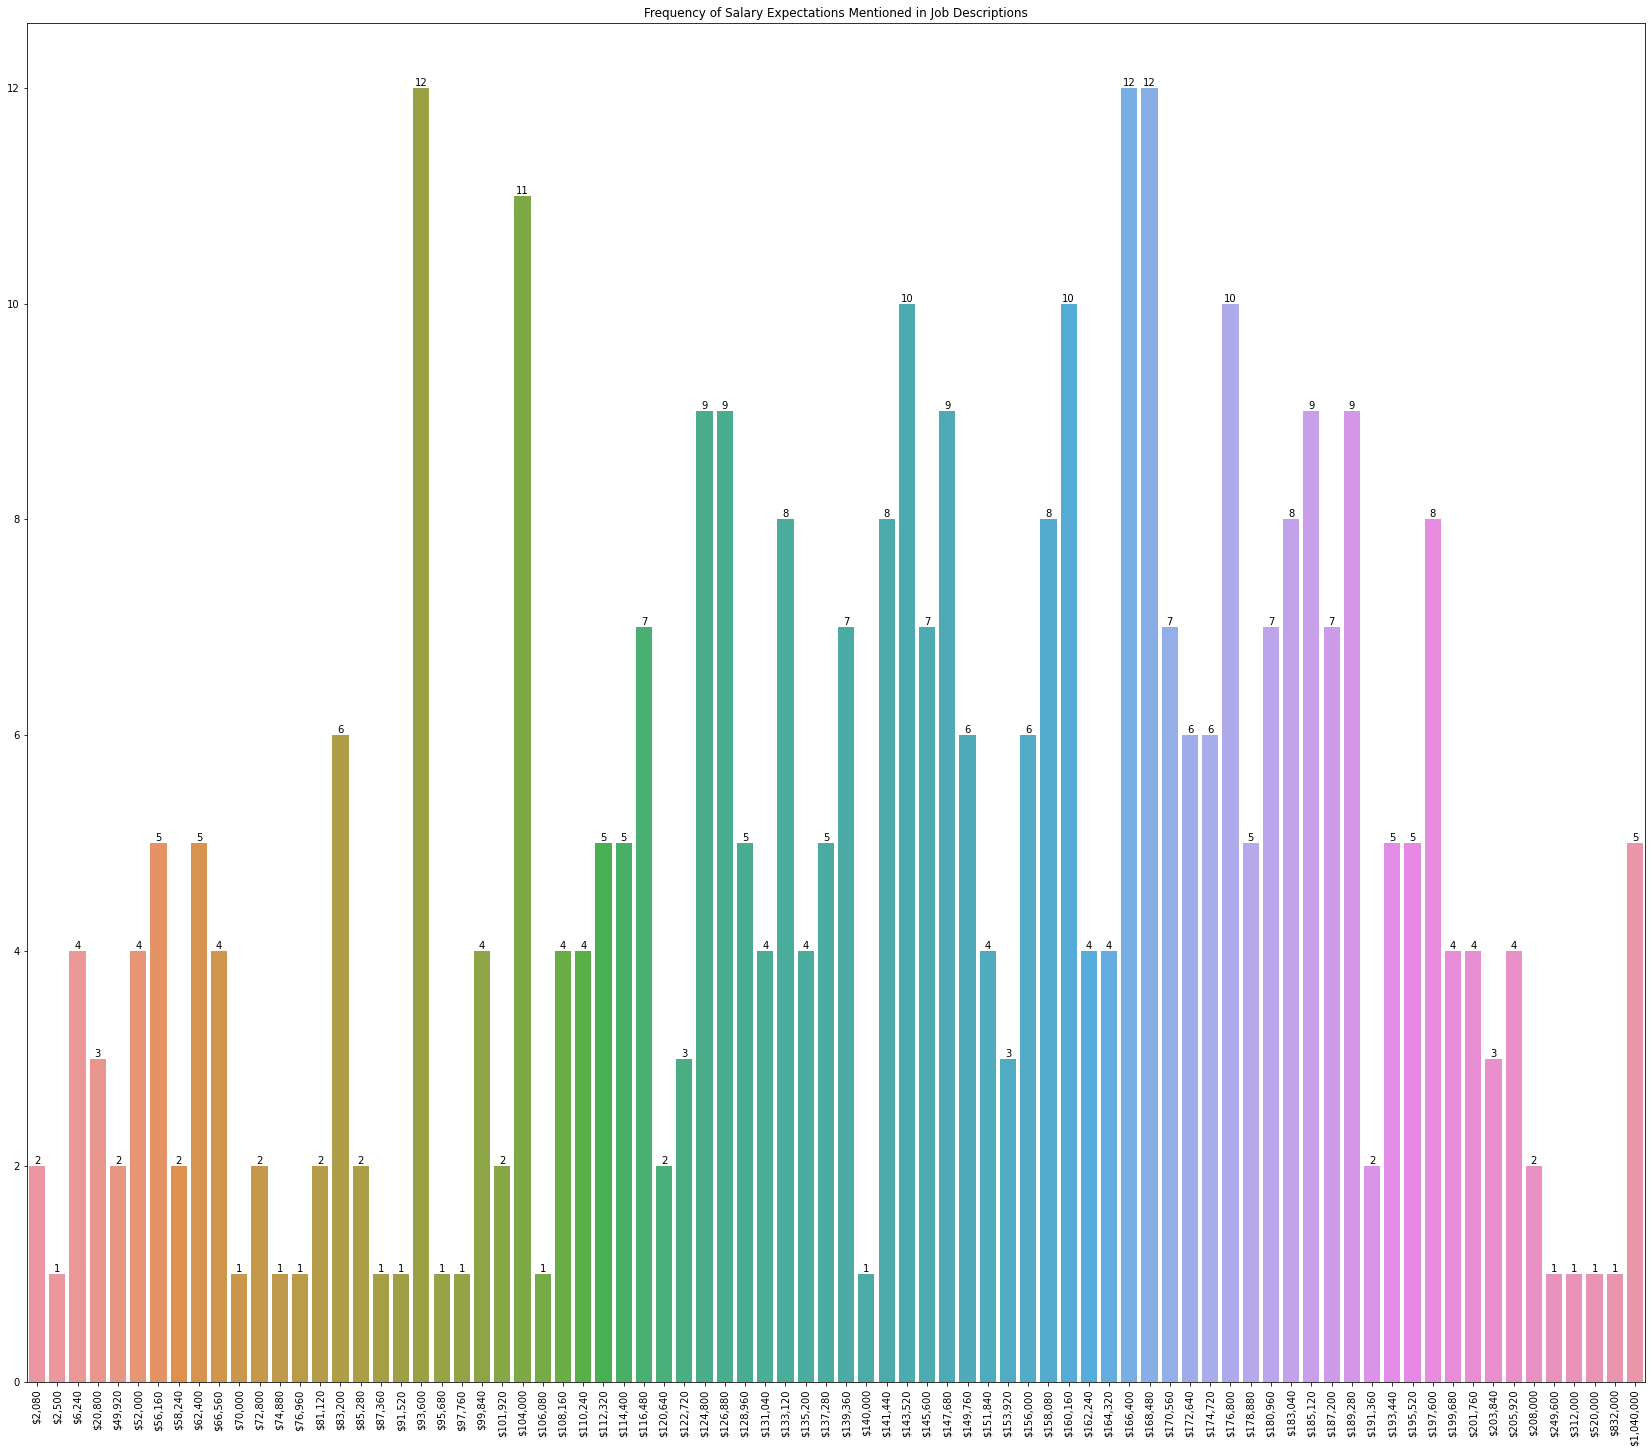

In [191]:
salary_expectations = visualization_lists[2]
data_value_list = []
new_salary_expectations = []
index = []
value = []
for items in salary_expectations:
    try:
        money = items[0]
        money = int(money[1:].replace(",", ""))
        data_value_list.append((money, items[1]))
    except ValueError:
        continue
        
data_value_list.sort(key=lambda y:y[0])       
            
for items in data_value_list:
    x = "$" + str(f'{items[0]:,}')
    index.append(x)
    value.append(items[1])

plt.figure(figsize=(29,25))
plt.title("Frequency of Salary Expectations Mentioned in Job Descriptions")
ax = sns.barplot(x=index, y=value)
ax.bar_label(ax.containers[0])
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show

Text(0.5, 1.0, 'Job Educational Requirements Frequency')

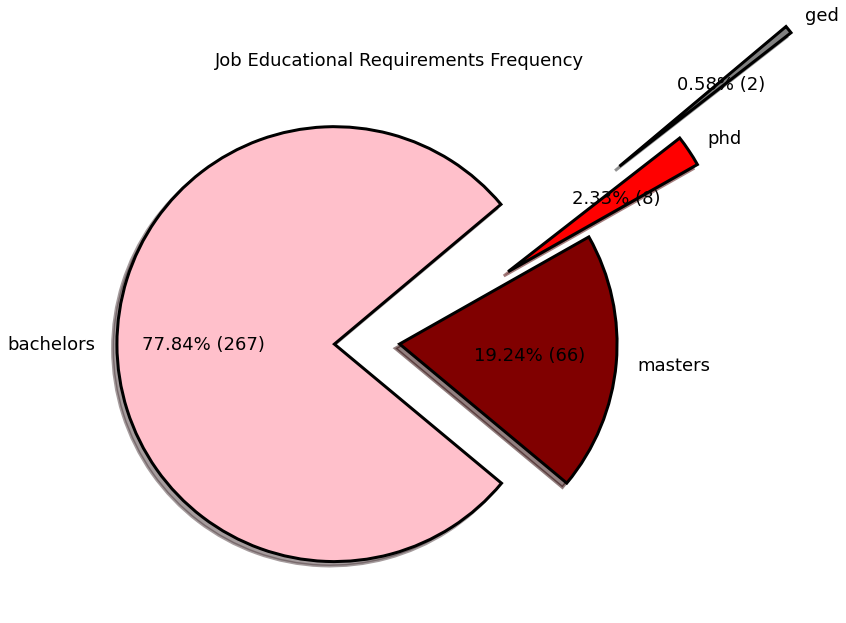

In [184]:
education = visualization_lists[3]
index = []
value = []
for items in education: 
    index.append(items[0])
    value.append(items[1])

def make_autopct(value):
    def my_autopct(pct):
        total = sum(value)
        val = int(round(pct*total/100.0))
        return '{p:.2f}% ({v:d})'.format(p=pct,v=val)
    return my_autopct

colors = ["pink", "maroon", "red", "gray"]

fig, ax = plt.subplots(figsize=(10,10))

patches, texts, pcts = ax.pie ( 
    value, labels=index, autopct=make_autopct(value), 
    wedgeprops={"linewidth": 3.0, "edgecolor": "black"},
    textprops={"size": "18", "color": "black",},
    startangle=40, 
    pctdistance=0.6,
    shadow = True,
    colors = colors,
    explode=(.3, 0, 0.6, 1.3))

ax.set_title("Job Educational Requirements Frequency", fontsize = 18)

In [81]:
education

[('bachelors', 267), ('masters', 66), ('phd', 8), ('ged', 2)]